# Text recognition task 1
-----------------------------------------
*José Carlos Aradillas jcaradillas@gmail.com*
    
-----------------------------------------
In this notebook, I document all the steps followed to complete the task for the Senior ML Research Engineer Test Task at Veriff.

I will split the statement of the problem and the several steps asked by Veriff in the following format:
>### Title of something asked by Veriff
> Statement and description of the problem

I document every step with comments and references preceding the different cells of code. I write also some inline code comments `# comment in the code` to clarify their porpuse.

Let's start:

>## 1. Prepare the dataset
>
>We will start with preparing our dataset. For this step, you will need the [EMNIST](https://www.westernsydney.edu.au/icns/reproducible_research/publication_support_materials/emnist) dataset. This dataset is a set of handwritten character digits derived from the NIST Special Database 19 and the dataset structure that directly matches the MNIST dataset. Torchvision provides a built-in `torchvision.dataset` [module 
for the EMNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html).

First of all, let's import all the neccesary libraries that will be use in the code to solve the task.

In [428]:
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torchvision import transforms as T
import random
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import VisionDataset
from typing import Any, Callable, List, Optional, Tuple
import time

Once the libraries have been imported, let's initialize the random seeds of every library I will use to randomize things, with the aim of achieving reproducibility. 

Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms and furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds [Reproducibility in Pytorch](https://pytorch.org/docs/stable/notes/randomness.html).

However, let's limit the number of sources of nondeterministic behavior for a specific platform, device, and PyTorch release:

In [2]:
random.seed(60)
np.random.seed(60)
_=torch.manual_seed(60)

>* Generate random sequences of random length (constrained to minimum 3, maximum 10) using characters from the EMNIST dataset.
>
>* Use the bymerge split that consists of 814,255 characters with 47 unbalanced classes. [The built-in implementation](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html) provides an argument that specifies which one to use.
>
>* Apply RandomAffine transformations on each character with the following specifications: degrees=20, translate=(0.2, 0.1), scale=(0.7, 1.15) while creating sequence images.
>
>* There should be at least 50,000 generated samples in your dataset.

**Solution:**
First of all, let's download the EMNIST dataset. I create a trainset and testset objects setting the path where to download (if not previously downloaded) in `data_path = '~/.pytorch/EMNIST_data/'`, the bymerge split setting `split = 'bymerge'` and apply the RandomAffine transformations on each character in the `transform` argument.

I also set a `trainloader` and a `testloader` objects with `batch_size=1`and `shuffle=True` to create the random sequences from this dataset. The generation of the random sequences will be done in the next cell.

*Note that in the `transform` argument I also indicate that the images are converted into tensors, with the aim of concatenating the sequences using tensors (for me is more confortable than concatenating PIL Images).*

In [187]:
# Define a transform to load the data as Tensors
data_path = '~/.pytorch/EMNIST_data/'
split = 'bymerge'
transform = T.Compose([
    T.RandomAffine(degrees=20, translate=(0.2, 0.1), scale=(0.7, 1.15)),
    T.ToTensor(),])

# Download and load the EMNIST training  data
trainset = datasets.EMNIST(data_path, split=split, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# Download and load the EMNIST test data
testset = datasets.EMNIST(data_path, split=split, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

In this cell I would check that the dataset in the **bymerge** split consists of 814255 characters with 47 unbalanced classes as it is commented in the statement:

>* Use the bymerge split that consists of 814,255 characters with 47 unbalanced classes. [The built-in implementation](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html) provides an argument that specifies which one to use.

In [4]:
train_size = len(trainset)
test_size = len(testset)
n_classes = len(np.unique(torch.concat([trainset.targets, testset.targets])))
print('The trainset has {} samples.'.format(train_size))
print('The testset has {} samples.'.format(test_size))
print('The total number of samples is {}.'.format(train_size+test_size))
print('The total number of classes in the set is {}.'.format(n_classes))

The trainset has 697932 samples.
The testset has 116323 samples.
The total number of samples is 814255.
The total number of classes in the set is 47.


We also can check that the classes are unbalanced if we plot the histogram of the targets in the training set.

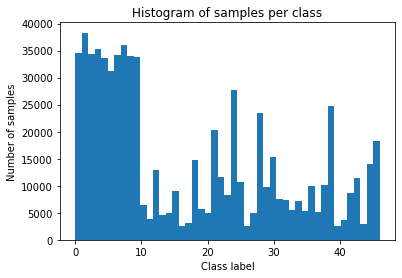

In [5]:
plt.hist(trainset.targets.numpy(), n_classes)
plt.title('Histogram of samples per class')
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.show()

As you can see in the previous histogram, the trainset is unbalanced, the classes regarding the numerical digits (from 0 to 9) has around 35k samples and the rest of characters vary from few thousands to 30k samples.

Now we check the type and the sizes of the loaded images using the trainloader (remember batch size of 1 and shuffled in order to build later our sequence dataset).

In [6]:
dataiter = iter(trainloader)   #To iterate through the dataset
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
print(labels)

<class 'torch.Tensor'>
torch.Size([1, 1, 28, 28])
torch.Size([1])
tensor([46])


In the previous output, we can check that the images ar torch tensors and their size is 28x28 and has 1 channel, therefore they are gray images. The labels are an unique digit that indicate the class.

Now let's show some somples (in this case 10, setting `n_samples_per_class=10` in the following code. This code looks for the images in the training set and built an image concatenating all the images for the same class in the same column. The samples of the classes are ordered.

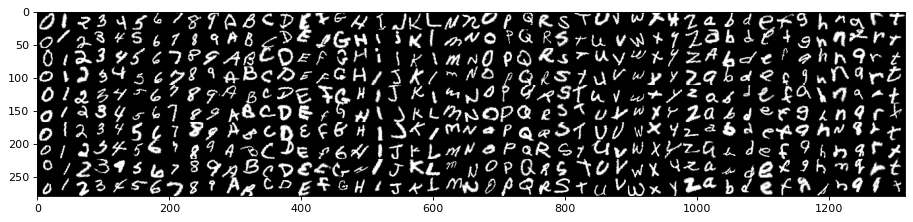

In [7]:
dataiter = iter(trainloader)
n_samples_per_class = 10
image_list=[[]]*n_classes
counter = 0
while counter<n_samples_per_class*n_classes:
    new_image, new_label = dataiter.next()
    new_image = new_image.mT # Transpose the images, the original ones are not in the correct visual position.
    if not isinstance(image_list[new_label],torch.Tensor):
        counter+=1
        image_list[new_label] = new_image
    elif image_list[new_label].shape[2]<28*n_samples_per_class:
        image_list[new_label] = torch.concat([image_list[new_label], new_image],2)
        counter+=1
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(torch.concat(image_list,3).squeeze().numpy(), cmap='Greys_r')
plt.show()

Generating the random sequences of random length (constrained to minimum 3, maximum 10)...

In [8]:
'ses_mnist.png 56 7 9'.split()

['ses_mnist.png', '56', '7', '9']

**EMNIST images are transpose with respect to MNIST ones**

In [9]:
def generate_random_lengths(min_length=3, max_length=10, n_sequences=1):
    assert max_length>=min_length, 'max_length={} should be >= min_length={}'.format(max_length, min_length)       
    return np.random.randint(min_length, max_length+1, n_sequences) #max-length+1 so length 10 is also included

def create_folder(path):
    if not os.path.isdir(path):
        print('Creating root folder '+ path +'...') 
        try:
            os.mkdir(path)
        except OSError:
            print ('Creation of the directory {} failed'.format(path))
        else:
            print ('Successfully created the directory {}'.format(path))    

def save_sample(root, image, seq, idx, dataset='demo'):
    transformToPIL = T.ToPILImage() # transformer for saving Images as PIL    
    if isinstance(root, torch._six.string_classes):
        root = os.path.expanduser(root) # In case we use '~/.pytorch' path for example
    create_folder(root)
    database_path = os.path.join(root,'SEMNIST')
    create_folder(database_path)

    set_path = os.path.join(database_path,dataset+'set') # Check if set is train or test
    create_folder(set_path)
    
    set_img_path = os.path.join(set_path, 'img')
    set_labels_path = os.path.join(set_path, 'labels')
    create_folder(set_img_path)
    create_folder(set_labels_path)
    
    img_path = os.path.join(set_img_path,'semnist_' + dataset + '_' + '{:0>6}'.format(idx) + '.png') 
    seq_path = os.path.join(set_labels_path,'semnist_' + dataset + '_' + '{:0>6}'.format(idx) + '.txt')
    imagePIL = transformToPIL(image.squeeze())  
    imagePIL.save(img_path) # Saving image into path
    seq = ' '.join(list(map(str, list(seq.numpy())))) # Convert seq tensor into string
    
    f = open(seq_path, "w")
    f.write(seq)
    f.close()
    
def generate_sequences(dataloader, sequence_lengths, save = False, root='~/.pytorch/SEMNIST_data/', dataset='demo'):
    num_seq = len(sequence_lengths)
    num_source_characters = len(dataloader)
    num_target_characters = np.sum(num_seq)
    assert num_source_characters>=num_target_characters, 'There are not enough characters in the source dataset to generate {} sequences.'.format(num_seq)
    dataiter = iter(dataloader)
    if not save:
        image_list = []
        label_list = []
    for seq, seq_length in enumerate(tqdm(sequence_lengths)):
        generated_image = []
        generated_seq = []
        for ind in range(seq_length):
            char_image, char_label = dataiter.next()
            generated_image.append(char_image.mT) # Transpose the image because the original are not visually align
            generated_seq.append(char_label)
        generated_image = torch.concat(generated_image,3) # Concatenate (w dim) the characters images to build the sequence image.
        generated_seq = torch.concat(generated_seq)
        if save:
            save_sample(root,generated_image, generated_seq, seq, dataset=dataset)
        else:   
            image_list.append(generated_image)
            label_list.append(generated_seq)
    if not save:
        return image_list, label_list

With the following code, we will generate our dataset, which we will call `SEMNIST` (from Sequential EMNIST) and we will save the data following the next structure:

```
root/SEMNIST/
    trainset/
        img/
            semnist_train_abcdef.png
            semnist_train_tvwxyz.png
        labels/
            semnist_train_abcdef.txt
            semnist_train_tvwxyz.txt
            ...
    testset/
        img/
            semnist_test_abcdef.png
            semnist_test_tvwxyz.png
        labels/
            semnist_test_abcdef.txt
            semnist_test_tvwxyz.txt
        ...    
    demoset/
        img/
            semnist_demo_abcdef.png
            semnist_demo_tvwxyz.png
        labels/
            semnist_demo_abcdef.txt
            semnist_demo_tvwxyz.txt
        ...
        
```
In the structure showed above, you can notice that there are two main directories in the `SEMNIST` folder, the `trainset`folder and the `testset` one. Inside the folders, you can find all the images form each dataset in a subfolder called `img` with the name `semnist_train_abcdef.png`in the case of training samples in `.png` extension and `abcdef`is the index of the image. There is also a subfolder called `labels` with `semnist_train_abcdef.txt` a `.txt` file with the same identificator. This file contains a string with the sequence of labels. In the `testset` folder we have the same structure.

There also exist a `demoset`in order to try different modules of the code. This demoset has 10,000 samples.

In the statement of the task, they tell us the following about the sequences:

>* Generate random sequences of random length (constrained to minimum 3, maximum 10) using characters from the EMNIST dataset.
>
>* There should be at least 50,000 generated samples in your dataset.

To generate the lengths of the sequences, we will use the method `generate_random_lengths(min_length=3, max_length=10, n_sequences=1)` which generates `n_sequences` integers between `min_length` and `max_length` (included). This method returns an array with the `n_sequences` lengths.

As showed before, in the **EMNIST** training set (from which we will create the **SEMNIST** training set) we have 697,932 samples available. If we take sequences of lengths between 3 and 10, the mean length of a sequence is 6.5. It does it mean that we can generate the minimun number of 50,000 samples and even 100,000 since 100,000 sequences of mean length 6.5 characters means that the total number of expected characters in the SEMNIST train set is 650,000 that is less than 697,932.

So, the total number of sequences (`n_training_sequences`) in the new SEMNIST train set will be 100,000.

Following the same analysis we will generate 16,000 number of test sequences `n_test_sequences=16000`.

*In the task they tell us that the number of generated samples should be at least 50,000. We fullfill this constraint and we consider that generate more samples is better while having a bigger training set is it always in deep learning tasks.*

In [185]:
n_train_sequences = 100000
n_test_sequences = 16000
n_demo_sequences = 1000
train_seq_lengths = generate_random_lengths(min_length=3, max_length=10, n_sequences=n_train_sequences)
test_seq_lengths = generate_random_lengths(min_length=3, max_length=10, n_sequences=n_test_sequences)
demo_seq_lengths = generate_random_lengths(min_length=3, max_length=10, n_sequences=n_demo_sequences)

Once we have the arrays with the sequence lengths for the 100,000 training set sequences and the 16,000 test set sequences, we have to generate the sequences and we will save it in disk to have it available to be loaded with a dataloader and save space in memory. It is not reccomended to have all the sequences loaded in the machine memory when training since it can saturate. 

In [188]:
SEMNIST_folder = '~/.pytorch/SEMNIST_data/'
generate_sequences(trainloader, train_seq_lengths, save = True, root=SEMNIST_folder, dataset='train')
generate_sequences(testloader, test_seq_lengths, save = True, root=SEMNIST_folder, dataset='test')
generate_sequences(trainloader, demo_seq_lengths, save = True, root=SEMNIST_folder, dataset='demo')

  4%|█▍                                      | 36/1000 [00:00<00:04, 202.81it/s]

Creating root folder /Users/jaradillas/.pytorch/SEMNIST_data/SEMNIST/demoset...
Successfully created the directory /Users/jaradillas/.pytorch/SEMNIST_data/SEMNIST/demoset
Creating root folder /Users/jaradillas/.pytorch/SEMNIST_data/SEMNIST/demoset/img...
Successfully created the directory /Users/jaradillas/.pytorch/SEMNIST_data/SEMNIST/demoset/img
Creating root folder /Users/jaradillas/.pytorch/SEMNIST_data/SEMNIST/demoset/labels...
Successfully created the directory /Users/jaradillas/.pytorch/SEMNIST_data/SEMNIST/demoset/labels


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 413.15it/s]


**Now we have our dataset created!!**

The next step is to build the Dataset class which help us to load the data during training, we also need a Dataloader which loads the Dataset and batch the data during batch training.

In [448]:
class SEMNIST(VisionDataset):
    def __init__(
        self,
        root: str,
        dataset: str = 'train',
        img_type: str = 'GrayScale',
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        assert os.path.isdir(self.root), 'Couldn`t find {} folder'.format(self._root)
        self._img_path = os.path.join(self.root, 'SEMNIST', dataset + 'set','img')
        self._labels_path = os.path.join(self.root, 'SEMNIST', dataset + 'set','labels')
        assert os.path.isdir(self._img_path), 'Couldn`t find {} folder'.format(self._img_path)
        assert os.path.isdir(self._labels_path), 'Couldn`t find {} folder'.format(self._labels_path)
        self.data_list = os.listdir(self._img_path)
        self.id = lambda id_extended: os.path.splitext(id_extended)[0]
        self.data_list = [self.id(path) for path in self.data_list]
        assert img_type in ['GrayScale', 'RGB'], 'Image type {} not supported'.format(img_type)
        self.img_type = img_type
    
    def __len__(self):
        return len(self.data_list)
   
    def __getitem__(self, index):
        img_path = os.path.join(self._img_path, self.data_list[index]+'.png')
        labels_path = os.path.join(self._labels_path, self.data_list[index]+'.txt')
        if self.img_type == 'RGB':
            img = Image.open(img_path).convert('RGB')
        elif self.img_type == 'GrayScale':
            img = Image.open(img_path)
        f = open(labels_path, "r")
        target = torch.tensor([int(x) for x in f.readline().split(' ')])
        f.close()
        if self.transform is not None:
            img = self.transform(img)
        return img, target

When performing batch training, Pytorch needs that all the input images to be tensors of the same shape (height and width). The next custom `collate_semnist` method is created to pad the smaller images in each batch to have the width of the widest image in the batch. It also pad the targets to have the same length.

The `collate_semnist` function will be an argument of the `Dataloader` which will load our batched data.

In [13]:
def collate_semnist(data):
    '''  
    We should build a custom collate_fn rather than using default collate_fn,
    as the width of every image is different and merging images (including padding) 
    is not supported by default. It also pad the labels sequences to have same length. 
    Args:
        data: list of tuple (image, label)
    Return:
        padded_img - Padded Image, tensor of shape (batch_size, channels, height, padded_width)
        width - Original width of each image(without padding), tensor of shape(batch_size)
        label - Padded sequence, tensor of shape (batch_size, padded_length)
        length - Original length of each sequence(without padding), tensor of shape(batch_size)
    '''

    # sorting is important for usage pack padded sequence when using lstm models. It should be in decreasing order.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, sequences = zip(*data)  # unzip the images from sequences to edit them more comfortably.
    width = [img.shape[2] for img in images] # save all the original images width
    length = [len(seq) for seq in sequences] # save all the original sequences length
    padded_img = torch.zeros(len(images), images[0].shape[0], images[0].shape[1], max(width)) # initialize the batch tensor with zeros
    padded_seq = torch.zeros(len(sequences), max(length)).long() # initialize the sequence tensor with zeros
    for i, img in enumerate(images):
        end = width[i]
        padded_img[i,:,:,:end] = img # insert the images in the first width part of each place 
    for i, seq in enumerate(sequences):
        end = length[i]
        padded_seq[i,:end] = seq  # insert the sequences in the first length part of each place 
    return padded_img, padded_seq, torch.from_numpy(np.array(width)), torch.from_numpy(np.array(length))

Now we have our dataset preparated and all the methods to load the dataset to feed our models, following the **Pytorch** Dataset framework. The steps for load the dataset are the following.
1. Instantiate the EMNIST trainset, with the command `trainset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'train', transform = transform)`. We apply `ToTensor()` and `Normalize` transformations in the images to get directly the inputs of our models.

2. Instantiate the EMNIST testset, aplying the same command sentence that for the training case but the argument in the call is `dataset='test'`.

3. Instantiate both dataloaders in shuffle mode to randomize the batches, we choose the batchsize and set the `collate_fn` argument with our custom `collate_semnist` explained above.

In [242]:
transform = T.Compose([T.ToTensor(),
                              T.Normalize((0.5,), (0.5,)),
                              ])
trainset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'train', transform = transform)
testset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'test', transform = transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_semnist)
testloader = DataLoader(testset, batch_size=64, shuffle=True, collate_fn=collate_semnist)

In the following code we show some imformation about the **SEMNIST** dataset we have just loaded. We check that the train set has 100,000 samples and the testset has 16,000 samples. We also show some samples of pairs image, target in the training set.

The train set has 100000 samples.
The test set has 16000 samples.


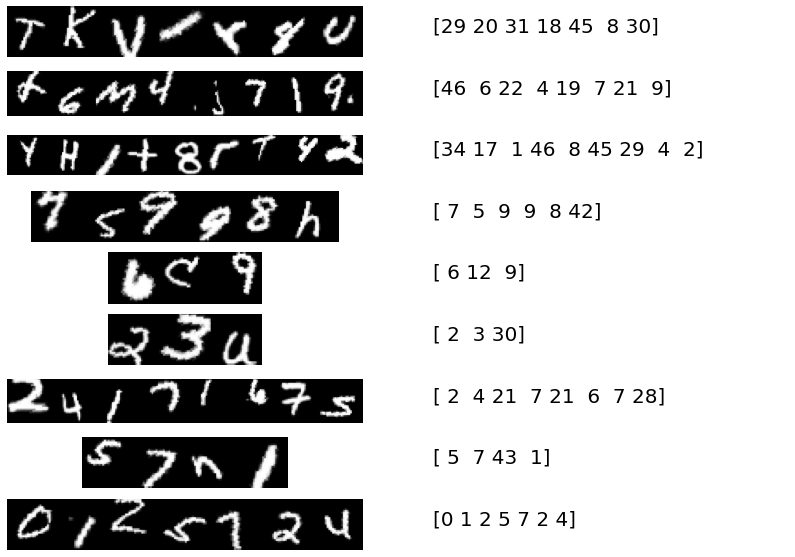

In [243]:
print('The train set has {} samples.'.format(len(trainset)))
print('The test set has {} samples.'.format(len(testset)))
num_plotted_samples = 9
fig, axs = plt.subplots(num_plotted_samples, 2,figsize=(14, 10))
for ind in range(num_plotted_samples): 
    img, label = trainset[ind]
    axs[ind,0].imshow(img.squeeze().numpy(), cmap='Greys_r')
    axs[ind,1].text(0,.5,str(label.numpy()), fontsize=20)
    axs[ind,0].axis('off')
    axs[ind,1].axis('off')

In [270]:
class CNN(nn.Module):
    def __init__(self,height,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.height = height
        self.nlabels = nlabels
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=3, stride=1, padding=1)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        
        self.conv3 = nn.Conv2d(16, 32, 7, stride=7, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(32,256)
        
        self.linear2 = nn.Linear(256, nlabels)
    
        self.activation = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 

        self.BN_1 = nn.BatchNorm2d(num_features=6)

        self.BN_2 = nn.BatchNorm2d(num_features=16)
        
        self.BN_3 = nn.BatchNorm2d(num_features=32)

        self.BN_4 = nn.BatchNorm1d(256)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        input_width = x.shape[3]
        output_width = int(input_width/self.height)
        x = self.conv1(x) 
        x = self.BN_1(x)
        x = self.activation(x) 
        x = self.pool(x)
        x = self.dropout(x) 
        x = self.conv2(x)
        x = self.BN_2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout(x) 
        x = self.conv3(x)
        x = self.BN_3(x)
        x = self.activation(x)
        x = self.dropout(x)
        # Pass the tensor through the Dense Layers
        x = x.squeeze(2)
        x = x.transpose(1,2)
        x = x.reshape(-1,32)
        x = self.linear1(x)
        x = self.BN_4(x)
        x = self.activation(x)
        x = self.dropout(x) 
        x = self.linear2(x)
        x = x.view(-1,output_width, self.nlabels)
        x = x.transpose(1,2)
        x = self.logsoftmax(x) 
        return x

In [271]:
my_net = CNN(height=28, nlabels=47,prob=0.25)

In [272]:
demo_dataloader = DataLoader(testset, batch_size=10, shuffle=False, collate_fn=collate_semnist)
dataiter = iter(demo_dataloader)
img, target, width, length = dataiter.next()
print(width, length)
out = my_net.forward(img)
out.shape

tensor([252, 252, 224, 224, 224, 196, 140, 140,  84,  84]) tensor([9, 9, 8, 8, 8, 7, 5, 5, 3, 3])


torch.Size([10, 47, 9])

In [330]:
class CNN_extended_GPU(CNN):
    
    def __init__(self,height,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(height,nlabels,prob)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss(reduction='none')             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels, widths, lengths in tqdm(trainloader):
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)
                
                mask = torch.ones_like(loss)
                for ind, length in enumerate(lengths):
                    mask[ind,length:] = 0
                 
                # Apply a mask to solve different lengths sequences
                loss = torch.mean(loss*mask)
                
                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                
                self.eval()
                
                running_loss = 0.
                
                for images,labels, widths, lengths in tqdm(validloader):
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                    
                                   
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out,labels)
                    
                    mask = torch.ones_like(loss)
                    
                    for ind, length in enumerate(lengths):
                        mask[ind,length:] = 0
                        
                    # Apply a mask to solve different lengths sequences   
                    loss = torch.mean(loss*mask)  

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    

            # set model back to train mode
            self.train()

            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0
        
        self.eval()
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels, widths, lengths in tqdm(dataloader):
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class.squeeze() == labels)
                mask = torch.ones_like(equals)
                for ind, length in enumerate(lengths):
                    mask[ind,length:] = 0
                equals*=mask
                accuracy += torch.sum(equals.type(torch.FloatTensor))/torch.sum(lengths)
                
            self.train()
            return accuracy/len(dataloader)

In [331]:
demoset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'demo', transform = transform)
demoloader = DataLoader(demoset, batch_size=64, shuffle=True, collate_fn=collate_semnist)

In [344]:
my_net = CNN_extended_GPU(height=28, nlabels=47,prob=0.2, epochs=20)
my_net.trainloop(trainloader,testloader)

100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.55it/s]


Epoch 0. Training loss: 1.183364, Validation loss: 0.744315, Time per epoch: 317.621748 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.47it/s]


Epoch 1. Training loss: 0.916602, Validation loss: 0.645137, Time per epoch: 219.382169 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 19.10it/s]


Epoch 2. Training loss: 0.858073, Validation loss: 0.639641, Time per epoch: 217.482807 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.00it/s]


Epoch 3. Training loss: 0.825386, Validation loss: 0.614321, Time per epoch: 218.748411 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.82it/s]


Epoch 4. Training loss: 0.805930, Validation loss: 0.610093, Time per epoch: 220.858059 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.95it/s]


Epoch 5. Training loss: 0.790907, Validation loss: 0.614778, Time per epoch: 217.990107 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.99it/s]


Epoch 6. Training loss: 0.783140, Validation loss: 0.611029, Time per epoch: 214.728812 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.35it/s]


Epoch 7. Training loss: 0.774072, Validation loss: 0.607949, Time per epoch: 210.809834 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.37it/s]


Epoch 8. Training loss: 0.767742, Validation loss: 0.623321, Time per epoch: 213.432980 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.47it/s]


Epoch 9. Training loss: 0.761119, Validation loss: 0.635046, Time per epoch: 212.187643 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.91it/s]


Epoch 10. Training loss: 0.756484, Validation loss: 0.622928, Time per epoch: 210.259603 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.65it/s]


Epoch 11. Training loss: 0.752934, Validation loss: 0.635951, Time per epoch: 208.305642 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.62it/s]


Epoch 12. Training loss: 0.748355, Validation loss: 0.625452, Time per epoch: 208.683239 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.24it/s]


Epoch 13. Training loss: 0.745670, Validation loss: 0.626214, Time per epoch: 208.754853 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.63it/s]


Epoch 14. Training loss: 0.742549, Validation loss: 0.623819, Time per epoch: 208.510983 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.24it/s]


Epoch 15. Training loss: 0.737951, Validation loss: 0.633786, Time per epoch: 210.215110 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.43it/s]


Epoch 16. Training loss: 0.736875, Validation loss: 0.648170, Time per epoch: 210.074216 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.51it/s]


Epoch 17. Training loss: 0.735045, Validation loss: 0.642328, Time per epoch: 210.804376 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.40it/s]


Epoch 18. Training loss: 0.733452, Validation loss: 0.639849, Time per epoch: 209.252223 seconds


100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.57it/s]

Epoch 19. Training loss: 0.731166, Validation loss: 0.653227, Time per epoch: 210.426390 seconds


In [352]:
my_no_dropout = CNN_extended_GPU(height=28, nlabels=47,prob=0, epochs=20)
my_no_dropout.trainloop(demoloader,testloader)

100%|█████████████████████████████████████████| 250/250 [00:14<00:00, 17.21it/s]


Epoch 0. Training loss: 2.226022, Validation loss: 2.331234, Time per epoch: 16.651561 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.00it/s]


Epoch 1. Training loss: 1.805569, Validation loss: 1.999347, Time per epoch: 15.896919 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.04it/s]


Epoch 2. Training loss: 1.488909, Validation loss: 1.568286, Time per epoch: 15.839876 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.58it/s]


Epoch 3. Training loss: 1.228361, Validation loss: 1.272163, Time per epoch: 15.453488 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.46it/s]


Epoch 4. Training loss: 1.030923, Validation loss: 1.146094, Time per epoch: 15.542779 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.73it/s]


Epoch 5. Training loss: 0.887962, Validation loss: 1.082083, Time per epoch: 15.350451 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.71it/s]


Epoch 6. Training loss: 0.772632, Validation loss: 1.005794, Time per epoch: 15.352922 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.59it/s]


Epoch 7. Training loss: 0.686654, Validation loss: 0.955472, Time per epoch: 15.436615 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.74it/s]


Epoch 8. Training loss: 0.609461, Validation loss: 0.923406, Time per epoch: 15.332375 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.67it/s]


Epoch 9. Training loss: 0.547682, Validation loss: 0.925390, Time per epoch: 15.375755 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.54it/s]


Epoch 10. Training loss: 0.495248, Validation loss: 0.931703, Time per epoch: 15.470349 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.67it/s]


Epoch 11. Training loss: 0.441823, Validation loss: 0.913137, Time per epoch: 15.412693 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.14it/s]


Epoch 12. Training loss: 0.395336, Validation loss: 0.891189, Time per epoch: 15.774478 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.59it/s]


Epoch 13. Training loss: 0.356033, Validation loss: 0.909158, Time per epoch: 15.448979 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.68it/s]


Epoch 14. Training loss: 0.320406, Validation loss: 0.941558, Time per epoch: 15.370599 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.56it/s]


Epoch 15. Training loss: 0.289350, Validation loss: 0.930182, Time per epoch: 15.474928 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.70it/s]


Epoch 16. Training loss: 0.263833, Validation loss: 0.983713, Time per epoch: 15.361374 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.81it/s]


Epoch 17. Training loss: 0.234163, Validation loss: 0.980185, Time per epoch: 15.285073 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.70it/s]


Epoch 18. Training loss: 0.215379, Validation loss: 0.983982, Time per epoch: 15.362872 seconds


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.77it/s]

Epoch 19. Training loss: 0.196771, Validation loss: 1.009724, Time per epoch: 15.368498 seconds


In [355]:
print(my_net.eval_performance(testloader))
print(my_net.eval_performance(demoloader))
print(my_no_dropout.eval_performance(testloader))
print(my_no_dropout.eval_performance(demoloader))

100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.21it/s]


tensor(0.5912)


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 19.16it/s]


tensor(0.6004)


100%|█████████████████████████████████████████| 250/250 [00:14<00:00, 17.20it/s]


tensor(0.5720)


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.79it/s]

tensor(0.9299)


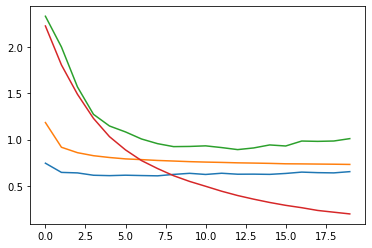

In [356]:
plt.plot(my_net.valid_loss_during_training)
plt.plot(my_net.loss_during_training)
plt.plot(my_no_dropout.valid_loss_during_training)
plt.plot(my_no_dropout.loss_during_training)

tensor([ 9,  5, 39, 21,  3, 28,  1])


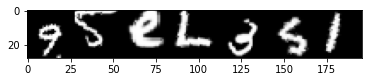

In [361]:
img, label = demoset[56]
plt.imshow(img.squeeze().numpy(), cmap='Greys_r')
img = img.reshape(1,img.shape[0], img.shape[1], img.shape[2])
print(label)

In [362]:
probs = my_no_dropout.forward(img)
top_p, top_class = probs.topk(1, dim=1)
top_class

tensor([[[ 4,  5, 39, 21,  3, 10,  1]]])

In [337]:
probs.shape

torch.Size([1, 47, 5])

In [412]:
def eval_performance(model, dataloader, mode='seqCER'):
    """
    accuracy = eval_performance(model, dataloader, mode='seqCER')
    
    Computes the eval performance of a given model over a given dataset.
    
    Args:
    
        model
    """
        
    loss = 0
    accuracy = 0

    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():

        for images,labels, widths, lengths in tqdm(dataloader):
            # Move input and label tensors to the default device
            images, labels = images.to(model.device), labels.to(model.device) 
            probs = model.forward(images)
            top_p, top_class = probs.topk(1, dim=1)
            equals = (top_class.squeeze() == labels)
            mask = torch.ones_like(equals)
            for ind, length in enumerate(lengths):
                mask[ind,length:] = 0
            equals*=mask
            if mode == 'totalCER':
                accuracy += torch.sum(equals.type(torch.FloatTensor))/torch.sum(lengths)
            else:
                accuracy += torch.mean(torch.sum(equals.type(torch.FloatTensor),1)/lengths)         
        model.train()
        return accuracy/len(dataloader)

# Let's try DenseNet

In [450]:
transform = T.Compose([T.Resize(224),
                       T.ToTensor(),
                              T.Normalize((0.5,), (0.5,)),
                              ])
demosetResized = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'demo', img_type='RGB', transform = transform)
demoloaderResized = DataLoader(demosetResized, batch_size=64, shuffle=False, collate_fn=collate_semnist)

In [471]:
model = models.densenet121(pretrained=True)
class MLP(nn.Module):
    def __init__(self,dimx=1024,hidden=500,nlabels=47, prob=0): 
        
        super().__init__()
        
        self.nlabels= nlabels
        
        self.linear1 = nn.Linear(dimx,hidden) #YOUR CODE HERE
    
        self.linear2 = nn.Linear(hidden,nlabels) #YOUR CODE HERE
    
        self.activation = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
        self.BN = nn.BatchNorm1d(1024)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        print(x.shape)
        output_width = x.shape[3]
        x = x.squeeze(2)
        x = x.transpose(1,2)
        x = x.reshape(-1,dimx)
        x = self.linear1(x)
        x = self.BN(x)
        x = self.activation(x)
        x = self.dropout(x) 
        x = self.linear2(x)
        x = x.view(-1,self.output_width, self.nlabels)
        x = x.transpose(1,2)
        x = self.logsoftmax(x) 
        return x

In [459]:
for param in model.parameters():
    param.requires_grad = False

classifier = MLP(1024, nlabels=47)
    
model.classifier = classifier

In [468]:
class Tran_Eval():
    
    
    def __init__(self,model,epochs=100,lr=0.001):
        
        self.model = model
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss(reduction='none')             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels, widths, lengths in tqdm(trainloader):
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.model.forward(images)

                #Your code here
                loss = self.criterion(out,labels)
                
                mask = torch.ones_like(loss)
                for ind, length in enumerate(lengths):
                    mask[ind,length:] = 0
                 
                # Apply a mask to solve different lengths sequences
                loss = torch.mean(loss*mask)
                
                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                
                self.eval()
                
                running_loss = 0.
                
                for images,labels, widths, lengths in tqdm(validloader):
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                    
                                   
                    out = self.model.forward(images)

                    #Your code here
                    loss = self.criterion(out,labels)
                    
                    mask = torch.ones_like(loss)
                    
                    for ind, length in enumerate(lengths):
                        mask[ind,length:] = 0
                        
                    # Apply a mask to solve different lengths sequences   
                    loss = torch.mean(loss*mask)  

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    

            # set model back to train mode
            self.train()

            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0
        
        self.eval()
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels, widths, lengths in tqdm(dataloader):
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.model.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class.squeeze() == labels)
                mask = torch.ones_like(equals)
                for ind, length in enumerate(lengths):
                    mask[ind,length:] = 0
                equals*=mask
                accuracy += torch.sum(equals.type(torch.FloatTensor))/torch.sum(lengths)
                
            self.train()
            return accuracy/len(dataloader)

In [470]:
model_with_train = Tran_Eval(model,epochs=10)
model_with_train.trainloop(demoloaderResized, demoloaderResized)

  0%|                                                    | 0/16 [01:39<?, ?it/s]


IndexError: tuple index out of range

In [417]:

evalloader = DataLoader(testset, batch_size=4, shuffle=False, collate_fn=collate_semnist)
eval_performance(my_no_dropout, demoloader, mode='totalCER')

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.11it/s]


tensor(0.9260)